In [1]:
import time
from typing import Optional, Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.__version__

'1.13.1+cu117'

In [4]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root='../models/mnist',
    train=True,
    transform=ToTensor(),
    download=True,
)

test_data = datasets.MNIST(
    root='../models/mnist',
    train=False,
    transform=ToTensor(),
    download=True,
)

In [5]:
class TrainHelper:
    @staticmethod
    def train(cnn: nn.Module,
              *,
              epochs: int,
              train_dataset: datasets.MNIST,
              test_dataset: Optional[datasets.MNIST] = None,
              print_results: bool = True,
              batch_size: int,
              device_name: str) -> List[float]:

        train_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=1)

        device = torch.device(device_name)

        cnn.to(device)
        cnn.train()

        optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
        loss_func = nn.CrossEntropyLoss()

        eval_results: List[float] = []

        for epoch in range(epochs):
            for images, labels in train_loader:
                images = Variable(images.to(device))
                labels = Variable(labels.to(device))

                output = cnn(images)
                loss = loss_func(output, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if test_dataset is not None:
                eval_result = TrainHelper.test(cnn, test_dataset, device)
                eval_results.append(eval_result)
                if print_results:
                    print(f"epoch {epoch}, accuracy = {eval_result}, loss = {loss.detach()}")
                cnn.train()

        return eval_results

    @staticmethod
    def test(cnn: nn.Module, test_dataset: datasets.MNIST, device=None) -> float:
        cnn.eval()
        loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=1)
        correct = 0
        incorrect = 0

        for images, labels in loader:
            if device is not None:
                images = images.to(device)

            results = cnn(images)
            predictions = results.detach().cpu().numpy().argmax(axis=1)
            oks = (predictions == labels.numpy()).sum()
            correct += oks
            incorrect += len(predictions) - oks

        return correct / (correct + incorrect)

    @staticmethod
    def train_models(models: List[nn.Module], device_name: str) -> Tuple[int, float]:
        """
        generator yields pair (trainable parameters count, best accuracy) for each network
        :param device_name: 'cuda' or 'cpu'
        """
        assert len(models) > 0

        for model in models:
            start = time.time()
            eval_results = TrainHelper.train(
                cnn=model,
                epochs=20,
                train_dataset=train_data,
                test_dataset=test_data,
                batch_size=512,
                device_name=device_name,
                print_results=False
            )
            end = time.time()
            best_acc = max(eval_results)
            params_count = TrainHelper.total_parameters_count(model)
            print(f"best accuracy = {best_acc}, parameters = {params_count}, training time = {end - start}")
            yield params_count, best_acc

    @staticmethod
    def total_parameters_count(model: nn.Module) -> int:
        return sum(np.prod(p.size()) for p in model.parameters())

    @staticmethod
    def print_parameters(model: nn.Module):
        print(f"total parameters = {TrainHelper.total_parameters_count(model)}")
        for p in model.parameters():
            print(f"size {np.prod(p.size())}: {p.size()}")

In [6]:
from dataclasses import dataclass
import torch.nn.functional as F


@dataclass(eq=True, unsafe_hash=True, frozen=True)
class Mode:
    is_maxpool: bool
    is_upch: Optional[bool]
    kernel_size: Optional[int]

    @property
    def padding(self) -> Optional[Tuple[int, int, int, int]]:
        return {
            3: (0, 1, 0, 1),
            4: (1, 1, 1, 1),
        }.get(self.kernel_size, None)

    @staticmethod
    def all() -> List['Mode']:
        return [
            Mode(is_maxpool=True, is_upch=None, kernel_size=None),
            Mode(is_maxpool=False, is_upch=False, kernel_size=2),
            Mode(is_maxpool=False, is_upch=False, kernel_size=3),
            Mode(is_maxpool=False, is_upch=False, kernel_size=4),
            Mode(is_maxpool=False, is_upch=True, kernel_size=2),
            Mode(is_maxpool=False, is_upch=True, kernel_size=3),
            Mode(is_maxpool=False, is_upch=True, kernel_size=4),
        ]


class DownSample(nn.Module):
    def __init__(self, mode: Mode, in_ch: int):
        super(DownSample, self).__init__()
        self.mode = mode

        if mode.is_maxpool:
            self.layer = nn.MaxPool2d(2)
            self.bn = None
            self.activation = None
        else:
            out_ch = in_ch * 2 if mode.is_upch else in_ch
            self.layer = nn.Conv2d(in_ch, out_ch, kernel_size=mode.kernel_size, stride=2, padding='valid')
            self.bn = nn.BatchNorm2d(out_ch)
            self.activation = nn.LeakyReLU(0.1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        _, _, h, w = x.size()

        if self.mode.padding is not None:
            x = F.pad(x, self.mode.padding, mode='constant')

        x = self.layer(x)
        _, _, h2, w2 = x.size()
        assert h == h2 * 2 and w == w2 * 2, f"{h}, {w} -> {h2}, {w2}"

        if self.bn is not None:
            x = self.bn(x)

        if self.activation is not None:
            x = self.activation(x)

        return x


class MyConvModel(nn.Module):
    def __init__(self, channels: int, mode: Mode):
        super(MyConvModel, self).__init__()

        c = channels
        m_upch = 2 if mode.is_upch else 1

        self.layers = nn.Sequential(
            self.conv(1, c, kernel_size=3),  # 28 - 26
            self.conv(c, c, kernel_size=3),  # 26 - 24
            DownSample(mode, c),  # 24 - 12

            self.conv(c * m_upch, c * 2, kernel_size=3),  # 12 - 10
            self.conv(c * 2, c * 2, kernel_size=3),  # 10 - 8
            DownSample(mode, c * 2),  # 8 - 4

            self.conv(c * 2 * m_upch, c * 4, kernel_size=3),  # 4 - 2
            self.conv(c * 4, c * 4, kernel_size=2),  # 2 - 1

            nn.Conv2d(c * 4, 10, kernel_size=1, padding='valid', bias=True),
            nn.Flatten(),
        )

    def conv(self, in_ch: int, out_ch: int, *, kernel_size: int):
        layers = []

        layers += [
            nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding='valid', bias=False),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.1)
        ]
        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor):
        return self.layers(x)

In [7]:
results = {
    mode: [] for mode in Mode.all()
}

In [8]:
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'

for i in range(4):
    for mode in Mode.all():
        models = [MyConvModel(ch, mode) for ch in reversed([4, 6, 8, 12, 16, 24, 32, 48, 64])]
        for pair in TrainHelper.train_models(models, device_name=device_name):
            results[mode].append(pair)

best accuracy = 0.9957, parameters = 820042, training time = 85.77092266082764
best accuracy = 0.9953, parameters = 462202, training time = 83.52538228034973
best accuracy = 0.9952, parameters = 206250, training time = 84.03653693199158
best accuracy = 0.9947, parameters = 116482, training time = 84.21329307556152
best accuracy = 0.9948, parameters = 52186, training time = 83.99793887138367
best accuracy = 0.9934, parameters = 29590, training time = 83.31093978881836
best accuracy = 0.9928, parameters = 13362, training time = 83.483811378479
best accuracy = 0.9929, parameters = 7636, training time = 83.1557035446167
best accuracy = 0.9877, parameters = 3502, training time = 82.99296188354492
best accuracy = 0.9945, parameters = 902538, training time = 92.190354347229
best accuracy = 0.9961, parameters = 508714, training time = 84.70083427429199
best accuracy = 0.9952, parameters = 227018, training time = 84.34747576713562
best accuracy = 0.9957, parameters = 128218, training time = 84.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


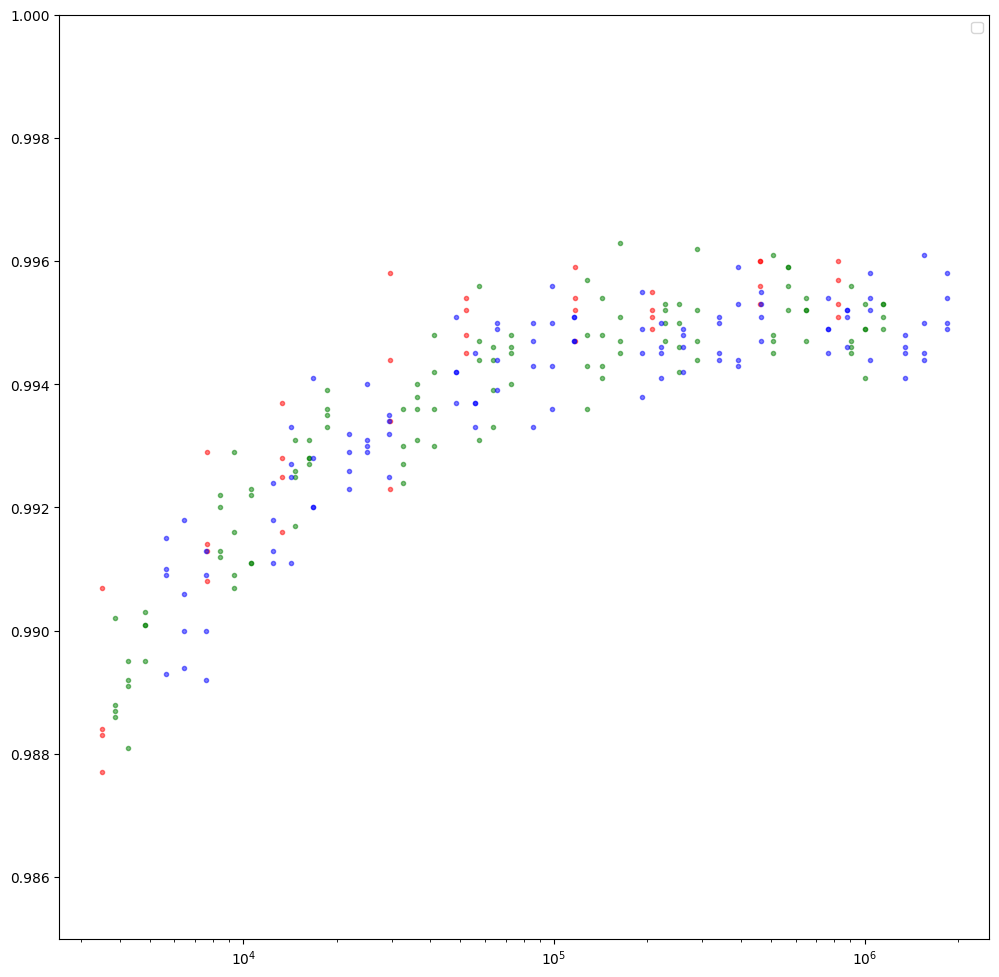

In [17]:
plt.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_ylim(0.985, 1)

modes = Mode.all()
colors = {
    modes[0]: 'red',
    modes[1]: 'green',
    modes[2]: 'green',
    modes[3]: 'green',
    modes[4]: 'blue',
    modes[5]: 'blue',
    modes[6]: 'blue',
}

for mode in modes:
    ax.scatter([p[0] for p in results[mode]], [p[1] for p in results[mode]], c=colors[mode], alpha=0.5, marker=r'.')

ax.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


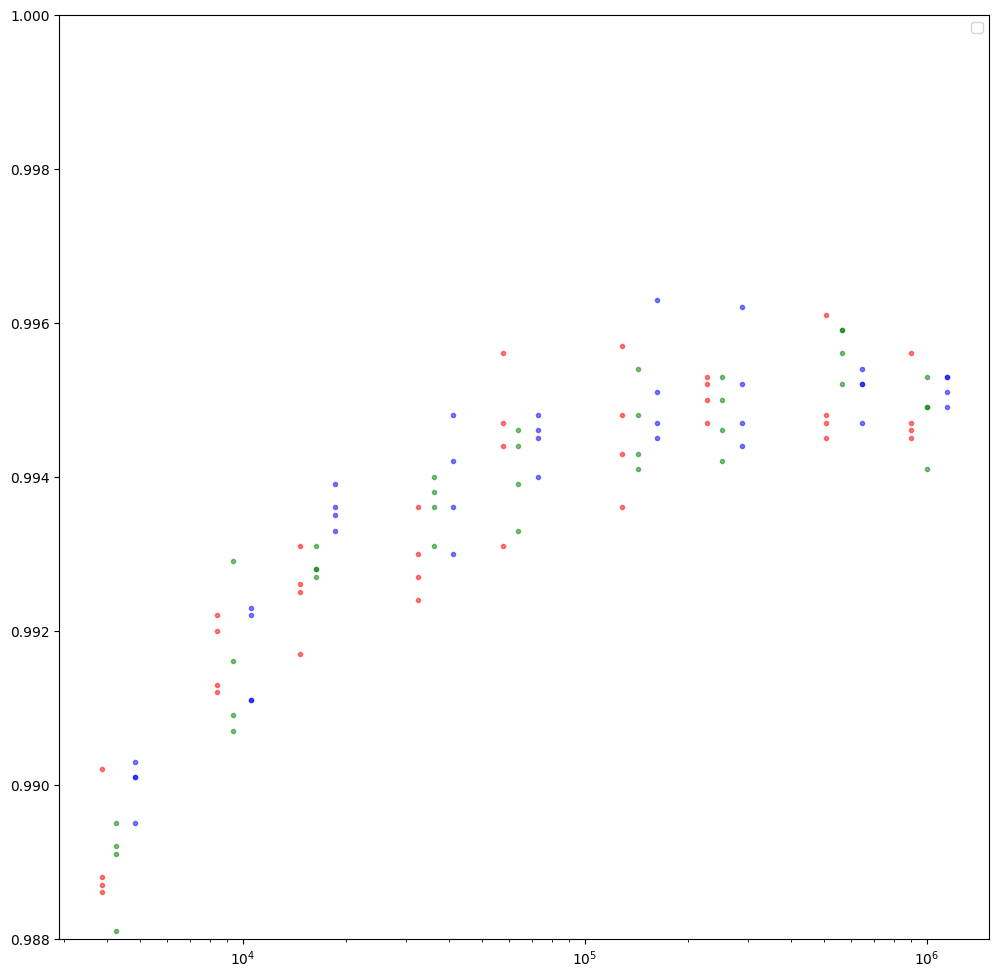

In [16]:
plt.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_ylim(0.988, 1)

modes = Mode.all()
colors = {
    modes[1]: 'red',
    modes[2]: 'green',
    modes[3]: 'blue',
}

for mode, color in colors.items():
    ax.scatter([p[0] for p in results[mode]], [p[1] for p in results[mode]], c=color, alpha=0.5, marker=r'.')

ax.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


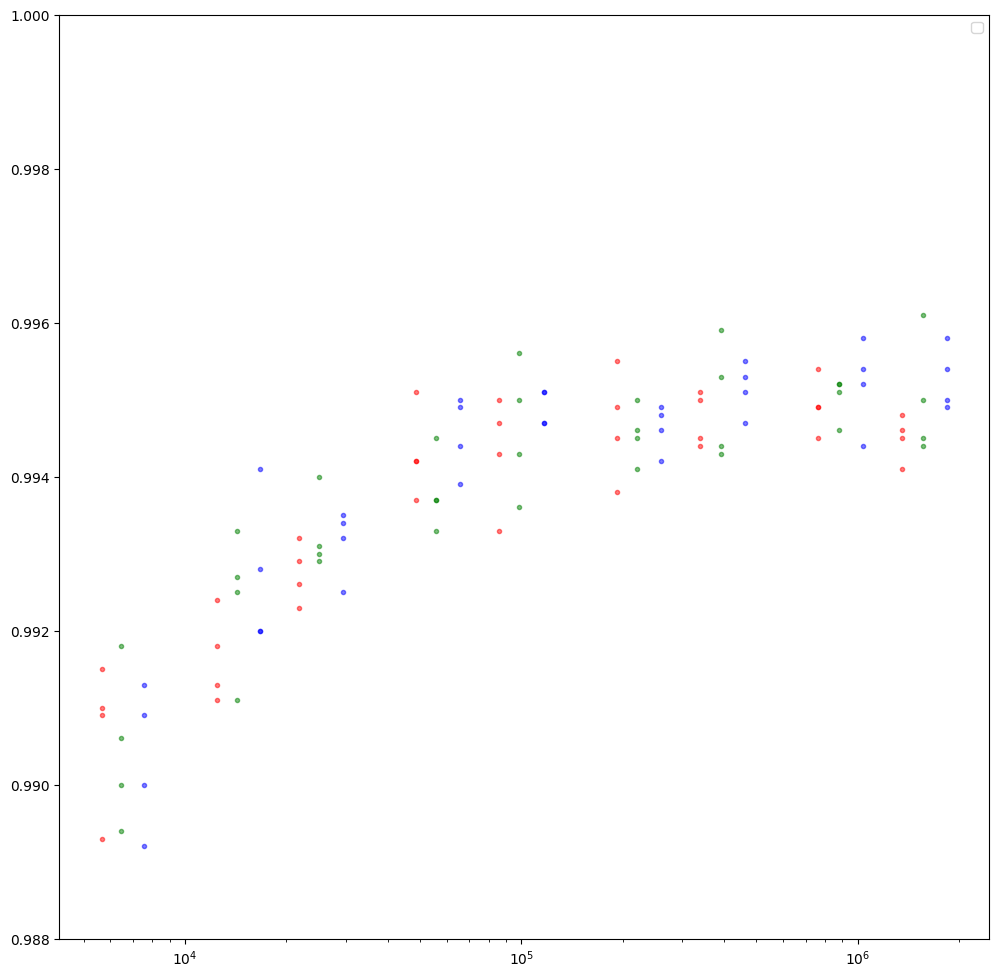

In [15]:
plt.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_ylim(0.988, 1)

modes = Mode.all()
colors = {
    modes[4]: 'red',
    modes[5]: 'green',
    modes[6]: 'blue',
}

for mode, color in colors.items():
    ax.scatter([p[0] for p in results[mode]], [p[1] for p in results[mode]], c=colors[mode], alpha=0.5, marker=r'.')

ax.legend()
plt.show()